# Welcome to Colab!

In [ ]:
!pip install tensorflow matplotlib

In [ ]:
 !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

--2025-12-22 10:19:01--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  2.12MB/s    in 17s     

2025-12-22 10:19:18 (1.67 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades/te

In [ ]:
IMG_SIZE = 256

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image

In [ ]:
 import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
train_dataset = tf.data.Dataset.list_files("facades/train/*.jpg")
train_dataset = train_dataset.map(load_image).shuffle(400).batch(1)

test_dataset = tf.data.Dataset.list_files("facades/test/*.jpg")
test_dataset = test_dataset.map(load_image).batch(1)

In [ ]:
def downsample(filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 4, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

def upsample(filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, 4, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    d1 = downsample(64)(inputs)
    d2 = downsample(128)(d1)
    d3 = downsample(256)(d2)
    d4 = downsample(512)(d3)

    u1 = upsample(256)(d4)
    u2 = upsample(128)(u1)
    u3 = upsample(64)(u2)

    outputs = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                               padding='same',
                                               activation='tanh')(u3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
 def Discriminator():
    inp = tf.keras.layers.Input(shape=[256,256,3])
    tar = tf.keras.layers.Input(shape=[256,256,3])

    x = tf.keras.layers.concatenate([inp, tar])

    x = downsample(64)(x)
    x = downsample(128)(x)
    x = downsample(256)(x)

    x = tf.keras.layers.Conv2D(1, 4, padding='same')(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_img = generator(input_img, training=True)

        real_out = discriminator([input_img, target_img], training=True)
        fake_out = discriminator([input_img, gen_img], training=True)

        g_loss = gen_loss(fake_out, gen_img, target_img)
        d_loss = disc_loss(real_out, fake_out)

    gen_opt.apply_gradients(zip(gen_tape.gradient(g_loss, generator.trainable_variables),
                                generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_tape.gradient(d_loss, discriminator.trainable_variables),
                                 discriminator.trainable_variables))

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
LAMBDA = 100  # common value for pix2pix

def gen_loss(fake_out, gen_img, target_img):
    gan_loss = loss_object(tf.ones_like(fake_out), fake_out)

    l1_loss = tf.reduce_mean(tf.abs(target_img - gen_img))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss


In [ ]:
def disc_loss(real_out, fake_out):
    real_loss = loss_object(tf.ones_like(real_out), real_out)
    fake_loss = loss_object(tf.zeros_like(fake_out), fake_out)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


In [ ]:
import tensorflow as tf

# 1. Loss object
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 2. Generator loss
LAMBDA = 100
def gen_loss(fake_out, gen_img, target_img):
    gan_loss = loss_object(tf.ones_like(fake_out), fake_out)
    l1_loss = tf.reduce_mean(tf.abs(target_img - gen_img))
    return gan_loss + (LAMBDA * l1_loss)

# 3. Discriminator loss
def disc_loss(real_out, fake_out):
    real_loss = loss_object(tf.ones_like(real_out), real_out)
    fake_loss = loss_object(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

# 4. Optimizers
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# 5. Train step
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_img = generator(input_img, training=True)

        real_out = discriminator([input_img, target_img], training=True)
        fake_out = discriminator([input_img, gen_img], training=True)

        g_loss = gen_loss(fake_out, gen_img, target_img)
        d_loss = disc_loss(real_out, fake_out)

    gen_grad = gen_tape.gradient(g_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gen_grad, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, discriminator.trainable_variables))


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    for inp, tar in train_dataset:
        train_step(inp, tar)
    print(f"Epoch {epoch+1} completed")


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed


In [ ]:
def show_output(model, input_img, target_img):
    prediction = model(input_img, training=False)

    plt.figure(figsize=(12,4))
    titles = ['Input', 'Ground Truth', 'Generated Output']
    images = [input_img[0], target_img[0], prediction[0]]

    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(titles[i])
        plt.imshow((images[i] + 1) / 2)
        plt.axis('off')

    plt.show()

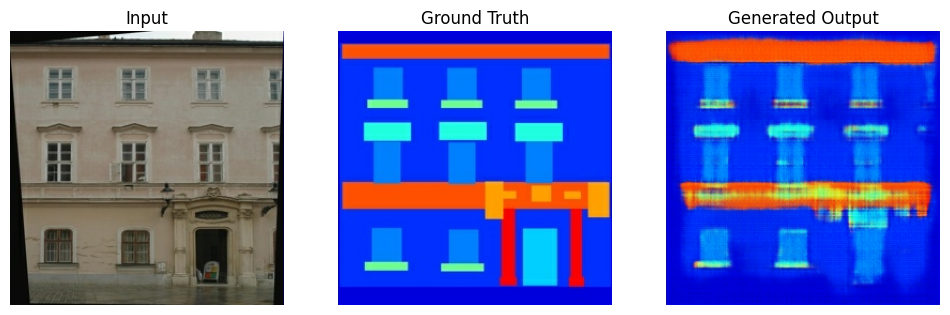

In [ ]:
for example in test_dataset.take(1):
    show_output(generator, example[0], example[1])

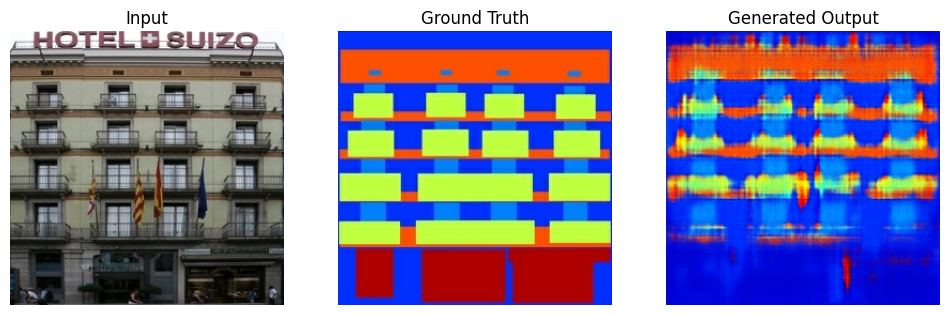

In [ ]:
for example in test_dataset.take(1):
    show_output(generator, example[0], example[1])

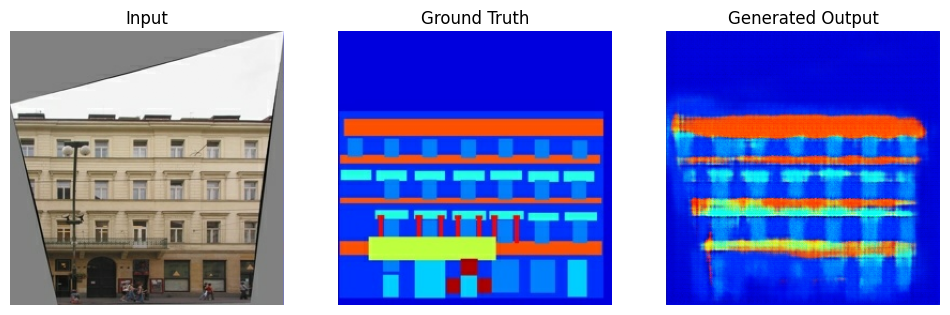

In [ ]:
for example in test_dataset.take(1):
    show_output(generator, example[0], example[1])

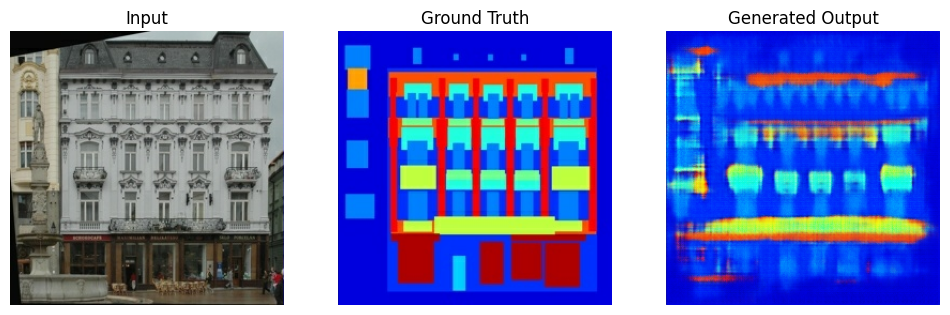

In [ ]:
for example in test_dataset.take(1):
    show_output(generator, example[0], example[1])

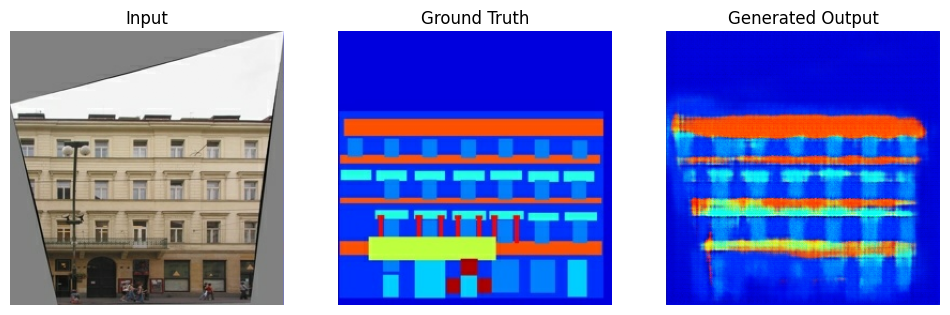

In [ ]:
for example in test_dataset.take(1):
    show_output(generator, example[0], example[1])